In [1]:
import random
from copy import deepcopy
import numpy as np
np.set_printoptions(linewidth=np.inf)
import pandas as pd
pd.set_option('display.max_columns', None)
from obspy import UTCDateTime
import datetime
import json
import pickle
import matplotlib.pyplot as plt
import math
from geographiclib.geodesic import Geodesic
# plt.rcParams['figure.figsize'] = [50, 200]
plt.rcParams['figure.figsize'] = [16, 12]
params = json.loads('''{
    "extents": {
        "s1": {
            "latMin": 22.0,
            "latMax": 40.0,
            "lonMin": 33.0,
            "lonMax": 62.0
        },
        "ut": {
            "latMin": -114.0,
            "latMax": -108.0,
            "lonMin": 36.0,
            "lonMax": 42.0
        }
    },
    "location": "s1",
    "maxDepth": 30.0,
    "maxStationElevation": 0.5,
    "trainingGeneratorSourceFile": "./Training/Event Files/S1+EV_TIME.gz",
    "trainingEventsFile": "./Training/Event Files/S1 Events 22-40-33-62 3 Min Picks.npz",
    "validationGeneratorSourceFile": "./Training/Event Files/S1+EV_TIME.gz",
    "validationEventsFile": "./Training/Event Files/S1 Events 22-40-33-62 3 Min Picks.npz",
    "arrivalProbsFile": "./Training/RSTT Model/S1 Dropouts.npy",
    "arrivalProbMods": {
        "Pg": 5.0,
        "Pn": 1.5,
        "Sg": 5.0,
        "Sn": 20.0
    },
    "cycleGrid": "False",
    "dropFactor": 0.0,
    "eventsPerExample": {
        "min": 3,
        "max": 4
    },
    "stationsPerBatch": {
        "min": 50,
        "max": 50
    },
    "timeShifts": {
        "min": -0.25,
        "max": 0.50
    },
    "batchSize": 1000,
    "samplesPerEpoch": 250000,
    "validationSamplesPerEpoch": 25000,
    "trainingWeight": 1.2,
    "epochs": 400,
    "trainingMode": "Associator",
    "models": {
        "associator": "./Models/Associator/Bigger Dense and GRUs 186 - L0.1199 - A0.9445 - P0.8586 - R0.9094",
        "matrixAssociator": "./Models/Associator/Matrix 398 - L0.7324 - A0.7799 - P0.8598 - R0.5669",
        "locator": "./Models/Locator/006 - L476.8028",
        "trainingAssociator": "./Training/Models/Associator Matrix/variables",
        "trainingLocator": "./Training/Models/Locator/variables"
    },
    "evalInFile": "./Inputs/S1 TEST.gz",
    "evalOutFile": "Evaluation.gz",
    "prlEvalOutFile": "PRL Evaluation.gz",
    "maxArrivals": 20,
    "minArrivals": 3,
    "minNucl": 3,
    "minMerge": 1,
    "maxLocatorArrivals": 20,
    "timeNormalize": 120,
    "associationWindow": 150,
    "evalWindow": 10.0,
    "phases": {
        "P": 0, "Pg": 0, "PcP": 0, "Pb": 0,
        "Pn": 1,
        "S": 2, "Sg": 2, "ScP": 2, "Lg": 2, "Sb": 2,
        "Sn": 3
    },
    "modelArch": {
        "associator": {
            "dense": [128, 64, 32, 32, 32],
            "grus": [256, 256]
        },
        "locator": {
            "dense1": [128, 64, 64],
            "transformers": [128, 128, 128],
            "heads": 3,
            "grus": [128, 128],
            "dense2": [128, 64]
        }
    }
}''')

In [1]:
import numpy as np
import pandas as pd
from obspy import UTCDateTime
import random
import rstt
from copy import deepcopy
from collections import deque
from itertools import chain, repeat
import math
modelPath = "./Training/RSTT Model/pdu202009Du.geotess"
phases = ['Pg','Pn','Lg','Sn']

def generateEventFile(params, trainingSet = True):
    if trainingSet:
        eventsFile = params['trainingEventsFile']
        generatorFile = params['trainingGeneratorSourceFile']
    else:
        eventsFile = params['validationEventsFile']
        generatorFile = params['validationGeneratorSourceFile']
    try:
        events = np.load(eventsFile, allow_pickle=True)['events'].flatten()[0]
        print("Training events loaded.") if trainingSet else print("Validation events loaded.")
    except:
        print("Events not loaded. Building from scratch.")
        extents = np.array(list(params['extents'][params['location']].values()))
        latRange = abs(extents[1] - extents[0])
        lonRange = abs(extents[3] - extents[2])
        phases = params['phases']
        events = {}
        inputArrivals = pd.read_pickle(generatorFile)
        groupedEvents = (inputArrivals.groupby('EVID').filter(lambda x: len(x) >= params['minArrivals'])).groupby('EVID')
        count = 0
        for eid, arrivals in groupedEvents:
            count += 1
            print("\rBuilding event list: " + str(count) + ' / ' + str(len(groupedEvents)), end='')
            eventArrivals = []
            first = UTCDateTime(arrivals.ARRTT.min())
            for i, arrival in arrivals.iterrows():
                lat = abs((arrival.STALAT - extents[0]) / latRange)
                lon = abs((arrival.STALON - extents[2]) / lonRange)
                thisArrival = [lat, lon, ((UTCDateTime(arrival.ARRTT) - first)/params['timeNormalize']), phases[arrival.PHASE], 1, arrival.ARRUNCERT, arrival.DROPOUT, arrival.EV_LAT, arrival.EV_LON, arrival.EV_DEPTH, arrival.EV_TIME]
                eventArrivals.append(thisArrival)
            events[eid] = np.array(eventArrivals)
        np.savez_compressed(eventsFile, events=events)
        print()
    eventList = list(events.keys())
    return events, eventList

def synthesizeLocatorEventsFromEventFile(params, events, eventList, trainingSet = True):
    duration = params['timeNormalize']
    maxArrivals = params['maxArrivals']
    dropFactor = params['dropFactor']
    batchSize = params['batchSize']

    while True:
        X = np.zeros((batchSize, maxArrivals, 11))
        #Setup - choose random events
        chosenEvents = random.sample(eventList, batchSize)
        for i in range(batchSize):
            thisEvent = events[chosenEvents[i]]
            #Randomly drop some arrivals from the event
            if trainingSet:
                drops = thisEvent[:,6]
                drops = drops + dropFactor*(1-drops) if dropFactor > 0 else drops*(1+dropFactor)
                drops = np.random.binomial(1,drops)
                idx = np.where(drops==1)[0]
                thisEvent = thisEvent[idx,:]
                #Add random arrival time errors, except for the first arrival of the primary event
                thisEvent[1:,2] += np.random.uniform(-thisEvent[1:,5]/duration, thisEvent[1:,5]/duration)
    
            #Sort by arrival time, drop arrivals with negative arrival times
            idx = np.argsort(thisEvent[:,2])
            remove = len(np.where((thisEvent[:,2] < 0))[0])
            idx = idx[remove:]
            thisEvent = thisEvent[idx]
            
            if len(thisEvent) == 0:
                #We lost all the valid arrivals, so scrap this training sample
                continue
            
            #Reset arrival times to start at 0
            thisEvent[:,2] -= thisEvent[0,2]
            
            #Truncate arrival over maximum allowed
            thisEvent = thisEvent[:maxArrivals]
            
            X[i,:len(thisEvent)] = thisEvent

        #Yield these training examples
        Y = X[:,0,7:]
        X = {"phase": X[:,:,3], "numerical_features": X[:,:,[0,1,2,4]]}
        yield X, Y

def synthesizeEventsFromEventFile(params, events, eventList, trainingSet = True):
    duration = params['timeNormalize']
    maxArrivals = params['maxArrivals']
    minTimeShift = params['timeShifts']['min']
    maxTimeShift = params['timeShifts']['max']
    minEvents = params['eventsPerExample']['min']
    maxEvents = params['eventsPerExample']['max']+1 # because using in np.random.randint
    dropFactor = params['dropFactor']

    while True:
        X = []
        Y = []
        for example in range(params['batchSize']):
            #Setup - choose random events, with the first being the primary event
            numEvents = np.random.randint(minEvents, maxEvents)
            chosenEvents = random.sample(eventList, numEvents)
            timeShifts = np.random.uniform(minTimeShift, maxTimeShift, size=numEvents-1)
            for i in range(0, len(chosenEvents)):
                thisEvent = events[chosenEvents[i]]
                #Randomly drop some arrivals from the event
                if trainingSet:
                    drops = thisEvent[:,6]
                    drops = drops + dropFactor*(1-drops) if dropFactor > 0 else drops*(1+dropFactor)
                    drops = np.random.binomial(1,drops)
                    idx = np.where(drops==1)[0]
                    thisEvent = thisEvent[idx,:]
                if i > 0:
                    #Add the arrivals from this event
                    sequence = np.append(sequence, thisEvent, axis=0)
                    #Shift the starting time of this event
                    currentLength = len(sequence)
                    sequence[currentLength:currentLength+len(thisEvent),2] += timeShifts[i-1]
                else:
                    sequence = thisEvent
                    primaryLength = len(sequence)
            
            #Add random arrival time errors, except for the first arrival of the primary event
            if trainingSet:
                timeShifts = np.random.uniform(-sequence[1:,5]/duration, sequence[1:,5]/duration)
                sequence[1:,2] += timeShifts
            
            #Drop the unneeded paramaters
            sequence = sequence[:,0:5]
    
            #Make label array, set the primary event to 1s
            labels = np.zeros([len(sequence)])
            labels[0:primaryLength] = 1
    
            #Sort by arrival time, drop arrivals with negative arrival times
            idx = np.argsort(sequence[:,2])
            remove = len(np.where((sequence[:,2] < 0))[0])
            idx = idx[remove:]
            sequence = sequence[idx,:]
            labels = labels[idx]
            
            #Reset primary event times
            ones = np.where(labels==1)
            if len(ones[0]) == 0:
                #We lost all the valid arrivals, so scrap this training sample
                continue
            sequence[ones,2] -= sequence[ones,2][0][0]
            idx = np.argsort(sequence[:,2])
            
            #Truncate arrivals over maximum allowed
            idx = idx[:maxArrivals]
            sequence = sequence[idx,:]
            labels = labels[idx]
            
            #Pad the end if not enough arrivals were selected
            padding = maxArrivals - len(sequence)
            if padding > 0:
                labels = np.pad(labels, (0,maxArrivals-len(labels)))
                sequence_ = np.zeros((maxArrivals, 5))
                sequence_[sequence.shape[0]:,2] = 0.0
                sequence_[:sequence.shape[0], :] = sequence
                sequence = sequence_
            
            X.append(sequence)
            Y.append(labels.astype(np.int32))

        #Yield these training examples
        X = np.array(X)
        Y = np.array(Y)
        X = {"phase": X[:,:,3], "numerical_features": X[:,:,[0,1,2,4]]}
        yield X, Y

def synthesizeEvents(params, locator=False):
    def get_TT(srcLatDeg, srcLonDeg, srcDepKm, rcvLatDeg, rcvLonDeg, rcvDepKm, phase, slbm):
        phase = phases[phase]
        # create a great circle from source to the receiver
        slbm.createGreatCircle(phase,
            rstt.deg2rad(srcLatDeg),
            rstt.deg2rad(srcLonDeg),
            srcDepKm,
            rstt.deg2rad(rcvLatDeg),
            rstt.deg2rad(rcvLonDeg),
            rcvDepKm)
    
        # get the distance and travel time from source --> receiver
        travelTimeSec = slbm.getTravelTime()   # compute travel time (sec)
        # get the travel time uncertainty
        travelTimeUncertSec   = slbm.getTravelTimeUncertainty()
    
        return travelTimeSec, travelTimeUncertSec

    def extentsCheck(extents):
        latRange = abs(extents[1] - extents[0])
        lonRange = abs(extents[3] - extents[2])
        a = (math.sin(math.radians(latRange)/2)**2) + (math.cos(math.radians(extents[0])) * math.cos(math.radians(extents[1])) * (math.sin(math.radians(lonRange/2))**2))
        maxSep = math.degrees(2*math.asin(min(1,math.sqrt(a))))
        print('Max event to receiver separation in degrees:', maxSep)
        
    def haversine(lat1, lon1, lat2, lon2):
        """
        Calculate the great circle distance between every combination of two points
        on the earth (specified in decimal degrees)
        """
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        lat1 = lat1[:, np.newaxis]
        lon1 = lon1[:, np.newaxis]
        
        dlat = lat2 - lat1
        dlon = lon2 - lon1
    
        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6368.1 * c
        bucket = (km/100).astype(int)
        bucket = np.clip(bucket, 0, 11)
        return bucket
    
    # instantiate an RSTT object
    slbm = rstt.SlbmInterface()
    # load the velocity model
    slbm.loadVelocityModel(modelPath)
    # load the arrival probabilities
    arrivalProbs = np.load(params['arrivalProbsFile']) # Phase (Pg, Pn, Lg, Sn), Distance (0-11), Magnitude (0-5)
    
    # read in all the parameters first to avoid redundant lookups. Really just more readable
    timeWindow = params['timeNormalize']
    batchSize = params['batchSize']
    maxArrivals = params['maxArrivals']
    minTimeShift = params['timeShifts']['min']
    maxTimeShift = params['timeShifts']['max']
    minEvents = params['eventsPerExample']['min']
    maxEvents = params['eventsPerExample']['max']+1 # because using in np.random.randint
    minStations = params['stationsPerBatch']['min']
    maxStations = params['stationsPerBatch']['max']+1 # because using in np.random.randint
    extents = np.array(list(params['extents'][params['location']].values())+[params['maxDepth'],params['maxStationElevation']])
    latRange = abs(extents[1] - extents[0])
    lonRange = abs(extents[3] - extents[2])
    arrivalProbs = np.load(params['arrivalProbsFile'])/100 # Phase (Pg, Pn, Lg, Sn), Distance (0-11), Magnitude (0-5)
    arrivalProbs[0] = np.clip(arrivalProbs[0]*params['arrivalProbMods']['Pg'],0,1)
    arrivalProbs[1] = np.clip(arrivalProbs[1]*params['arrivalProbMods']['Pn'],0,1)
    arrivalProbs[2] = np.clip(arrivalProbs[2]*params['arrivalProbMods']['Sg'],0,1)
    arrivalProbs[3] = np.clip(arrivalProbs[3]*params['arrivalProbMods']['Sn'],0,1)
    cycleGrid = (params['cycleGrid'] == 'True')
    if cycleGrid:
        latMod = 0.
        lonMod = 0.
        gridDiv = 0.5
        gridStep = 0.01
        partial = True

    def processEventsLocator(events):
        eventsCycle = chain.from_iterable(repeat(events))
        examples = [deepcopy(next(eventsCycle)) for _ in range(batchSize)]

        X = np.zeros((batchSize,maxArrivals,9))
        for i in range(batchSize):
            examples[i][1:,2] += examples[i][1:,4]*np.random.uniform(-1,1,len(examples[i][1:]))
            examples[i][:,4] = 1.
            idx = np.argsort(examples[i][:,2])
            start = np.argmax(idx == 0)
            idx = idx[start:start+maxArrivals]
            examples[i] = examples[i][idx]
            X[i][:len(examples[i])] = examples[i]
        X = np.array(X)
        Y = X[:,0,5:]
        X = {"phase": X[:,:,3], "numerical_features": X[:,:,[0,1,2,4]]}
        return X, Y

    def processEventsAssociator(events):
        examplesList = [random.sample(range(len(events)), numEvents) for _ in range(batchSize)]
        examples = [[deepcopy(events[e]) for e in examplesList[ex]] for ex in range(len(examplesList))]

        # generate all the amounts to shift events and phases around
        timeMods = np.random.uniform(minTimeShift,maxTimeShift,batchSize*(numEvents-1))
        timeModsUsed = 0

        Y = np.zeros((batchSize, maxArrivals))
        X = np.zeros((batchSize, maxArrivals, 5))
        for i in range(batchSize):
            example = examples[i]
            for event in example[1:]:
                event[:,2] += timeMods[timeModsUsed]
                timeModsUsed += 1
            examples[i] = np.concatenate(example)
            examples[i][1:,2] += examples[i][1:,4]*np.random.uniform(-1,1,len(examples[i][1:]))
            examples[i][:,4] = 1.
            idx = np.argsort(examples[i][:,2])
            start = np.argmax(idx == 0)
            idx = idx[start:start+maxArrivals]
            Y[i,np.where(idx < len(example[0]))] = 1
            examples[i] = examples[i][idx][:,:5]
            X[i][:len(examples[i])] = examples[i]

        X = np.array(X)
        Y = np.array(Y)
        X = {"phase": X[:,:,3], "numerical_features": X[:,:,[0,1,2,4]]}
        return X, Y

    def processEventsAssociator2(events):
        initial = [deque(random.sample(range(len(events)), numEvents)) for e in range(int(batchSize/numEvents))]
        examplesList = []
        for seq in range(numEvents-1):
            rotatedExamples = deepcopy(initial)
            for eventList in rotatedExamples:
                eventList.rotate(seq+1)
            examplesList += rotatedExamples
        examplesList = initial + examplesList
        examples = [[deepcopy(events[e]) for e in examplesList[i]] for i in range(len(examplesList))]

        # generate all the amounts to shift events and phases around
        timeMods = np.random.uniform(minTimeShift,maxTimeShift,batchSize*(numEvents-1))
        timeModsUsed = 0

        Y = np.zeros((len(examples),maxArrivals))
        X = np.zeros((len(examples),maxArrivals,5))
        for i in range(len(examples)):
            example = examples[i]
            for event in example[1:]:
                event[:,2] += timeMods[timeModsUsed]
                timeModsUsed += 1
            examples[i] = np.concatenate(example)
            examples[i][1:,2] += examples[i][1:,4]*np.random.uniform(-1,1,len(examples[i][1:]))
            examples[i][:,4] = 1.
            idx = np.argsort(examples[i][:,2])
            start = np.argmax(idx == 0)
            idx = idx[start:start+maxArrivals]
            Y[i,np.where(idx < len(example[0]))] = 1
            examples[i] = examples[i][idx][:,:5]
            X[i][:len(examples[i])] = examples[i]

        X = np.array(X)
        Y = np.array(Y)
        X = {"phase": X[:,:,3], "numerical_features": X[:,:,[0,1,2,4]]}
        return X, Y

    while(True):
        # Create a random numbers of events per training example...
        # ...and a random numbers of receiving stations to be used for each training example
        numEvents = np.random.randint(minEvents, maxEvents)
        numStations = np.random.randint(minStations, maxStations)
        totalEvents = int(batchSize/numEvents)
        genEvents = np.zeros((totalEvents, 6))
        stations = np.zeros((numStations, 6))
        if cycleGrid and partial:
            genEvents[:,0] = np.random.uniform(0+latMod, gridDiv+latMod, totalEvents) # evLat
            genEvents[:,1] = np.random.uniform(0+lonMod, gridDiv+lonMod, totalEvents) # evLon
            genEvents[:,2] = np.random.uniform(0, 1, totalEvents) # evDepth
            stations[:,0] = np.random.uniform(0+latMod, gridDiv+latMod, numStations) # stLat
            stations[:,1] = np.random.uniform(0+lonMod, gridDiv+lonMod, numStations) # stLon
            stations[:,2] = np.random.uniform(0, 1, numStations) # stDepth
            
            # Update the sliding box in which to generate the next set of events
            latMod = (latMod+gridStep)%(1-gridDiv)
            if latMod == 0:
                lonMod = (lonMod+gridStep)%(1-gridDiv)
        else:
            genEvents[:,0:3] = np.random.rand(totalEvents, 3) # [evLat, evLon, evDepth]
            stations[:,0:3] = np.random.rand(numStations, 3) # [stLat, stLon, stDepth]
            # partial = not partial
            

        # Calculate the denormalized event and station latitudes
        genEvents[:,3] = genEvents[:,0]*latRange + extents[0]
        stations[:,3] = stations[:,0]*latRange + extents[0]
        # Calculate the denormalized event and station longitudes
        genEvents[:,4] = genEvents[:,1]*lonRange + extents[2]
        stations[:,4] = stations[:,1]*lonRange + extents[2]
        # Calculate the denormalized event and stations depths
        genEvents[:,5] = genEvents[:,2]*extents[4]
        stations[:,5] = -stations[:,2]*extents[5] # because it's elevation, I think

        # Generate random magnitudes (as buckets for looking up in the arrival probability table)
        # Calculate the distances between stations and events and get the buckets for looking up in the probability table
        mags = np.random.randint(0, 6, totalEvents)
        dists = haversine(genEvents[:,3],genEvents[:,4],stations[:,3],stations[:,4]) # distance buckets as dists[event, station]

        # Lookup retention values for each training example, phase, event, station
        arrivals = arrivalProbs[:,dists,mags[:,np.newaxis]]
        arrivals = np.random.binomial(1,arrivals) # arrivals[phase][event][station]
        arrivals = np.argwhere(arrivals==1)

        # Build the events list
        events = np.full((len(arrivals),10),np.nan) # normal station lat, normal station lon, travel time, phase, travel time uncertainty, event lat, event lon, event depth, event time, event id
        currentPhase = 0
        for arrival in range(len(arrivals)):
            ph, ev, st = arrivals[arrival]
            try:
                tt, uncert = get_TT(genEvents[ev,3],genEvents[ev,4],genEvents[ev,5],stations[st,3],stations[st,4],stations[st,5],ph,slbm)
                events[currentPhase] = [stations[st,0], stations[st,1], tt, ph, uncert, genEvents[ev,3], genEvents[ev,4], genEvents[ev,5], 0, ev]
                currentPhase += 1
            except Exception as e:
        #                 print(e)
                pass
        events = events[~np.any(np.isnan(events), axis=1)] # Remove NaNs (from failed TT calculations)
        events = events[np.lexsort((events[:,2], events[:,-1]))] # Sort by event id, then by travel time
        evids, counts = np.unique(events[:,-1], return_counts=True) # Ensure there are at least a few arrivals for each event
        evids = evids[np.where(counts >= params['minArrivals'])]
        events = events[np.isin(events[:,-1],evids)]
        events[:,[2,4]] /= timeWindow # Normalize time values

        events = np.split(events[:,:-1], np.unique(events[:,-1], return_index=True)[1][1:]) # arrivals as an array of events
        for event in events:
            event[:,[2,8]] -= event[0,2] # convert travel time to arrival time, retain event time TODO: can this be done vectorized?
            event[:,8] *= timeWindow
        numEvents = len(events) if len(events) < numEvents else numEvents
        yield processEventsLocator(events) if locator else processEventsAssociator(events)

In [81]:
# synth = synthesizeEvents(params,False)
test = next(synth)
total = params['batchSize']*params['maxArrivals']
padding = np.sum(test[0]['numerical_features'][:,:,3]==0)
positiveProp = np.sum(test[1]==1) / (total-padding)
y = np.bincount(test[0]['phase'].flatten().astype(int))
y[0] -= padding
ii = np.nonzero(y)
phaseProportions = np.vstack((ii,y[ii]/(total-padding))).T
print("Total:",total)
print("Padding:",padding,padding/total)
print("Ones:",np.sum(test[1]==1),positiveProp)
print("Phases:\n",phaseProportions)
print(test[1][0])
print(test[0]['numerical_features'][0])

# synthEvents = synthesizeLocatorEventsFromEventFile(params,validationEvents,validationEventList,False)
# test = next(synthEvents)
# print(test[1][0])
# print(test[0]['numerical_features'][0])
# print(test[0]['phase'][0])

Total: 20000
Padding: 8681 0.43405
Ones: 4004 0.353741496599
Phases:
 [[ 0.          0.1664458 ]
 [ 1.          0.73981801]
 [ 2.          0.07341638]
 [ 3.          0.01855288]]
[ 1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[[ 0.1093685   0.12499846  0.          1.        ]
 [ 0.29465833  0.68309575  0.05849042  1.        ]
 [ 0.85976498  0.25700272  0.10165011  1.        ]
 [ 0.28954109  0.34344657  0.21335569  1.        ]
 [ 0.93266816  0.11991539  0.28393716  1.        ]
 [ 0.27191608  0.82152349  0.38667881  1.        ]
 [ 0.0222185   0.38229028  0.41763547  1.        ]
 [ 0.68548383  0.49091195  0.61940999  1.        ]
 [ 0.70524569  0.40555803  0.94300468  1.        ]
 [ 0.34788544  0.40433778  1.12885205  1.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.       

In [3]:
import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Embedding, Reshape, concatenate, Dense, Bidirectional, GRU, Dropout, Flatten, MultiHeadAttention, LayerNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
import logging
import json
from PhaseAssociatorGenerator import generateEventFile, synthesizeEventsFromEventFile, synthesizeEvents, synthesizeLocatorEventsFromEventFile
from Utils import trainingResults

@tf.autograph.experimental.do_not_convert
def PhaseAssociator(epochs=10, weight=1.0):
    logging.getLogger("tensorflow").setLevel(logging.ERROR)
    class saveCb(Callback):
        def on_epoch_end(self, epoch, logs=None):
            # print('\n' + str(model.layers[1].get_weights()[0])) # weights of embedded layer
            modelName = '%03d - L%.4f - A%.4f - P%.4f - R%.4f' % (epoch, logs['val_loss'], logs['val_acc'], logs['val_precision'], logs['val_recall'])
            # modelName = '%03d - L%.4f - A%.4f - P%.4f - R%.4f' % (epoch, logs['loss'], logs['acc'], logs['precision'], logs['recall'])
            model.save("./Training/Models/Associator1/"+modelName)
    
    def buildModel(modelArch):
        outputs = []
        inputs = []
        numericalInputs = Input(shape=(None,4), name='numerical_features')
        outputs.append(numericalInputs)
        inputs.append(numericalInputs)
        categoricalInputs = Input(shape=(None,1), name='phase')
        embed = Embedding(4, 2, trainable=True, embeddings_initializer=RandomNormal())(categoricalInputs)
        embed = Reshape(target_shape=(-1,2))(embed)
        outputs.append(embed)
        inputs.append(categoricalInputs)
        outputs = concatenate(outputs)
            
        for units in modelArch['dense']:
            outputs = Dense(units=units, activation=tf.nn.relu)(outputs)
        for units in modelArch['grus']:
            outputs = Bidirectional(GRU(units, return_sequences=True))(outputs)

        outputs = Dense(units=1, activation=tf.nn.sigmoid)(outputs)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(name='precision'), Recall(name='recall')], weighted_metrics=['acc'])
        return model
    
    model = buildModel(params['modelArch']['associator'])
    try:
        model.load_weights(params['models']['trainingAssociator'])
        print("Loaded previous weights.")
    except Exception as e:
        print(e)
        print("No previous weights loaded.")

    # generator = synthesizeEventsFromEventFile(params, trainingEvents, trainingEventList)
    generator = synthesizeEvents(params)
    vgen = synthesizeEventsFromEventFile(params, validationEvents, validationEventList)
    # vgen = synthesizeEvents(params)
    return model.fit(generator,
                     validation_data=vgen,
                     steps_per_epoch= params['samplesPerEpoch']/params['batchSize'],
                     validation_steps = params['validationSamplesPerEpoch']/params['batchSize'],
                     epochs=epochs,
                     callbacks=[saveCb()],
                     class_weight={0: 1.0, 1: weight},
                     verbose=1)

@tf.autograph.experimental.do_not_convert
def Locator(epochs=10):
    logging.getLogger("tensorflow").setLevel(logging.ERROR)
    class saveCb(Callback):
        def on_epoch_end(self, epoch, logs=None):
            # print('\n' + str(model.layers[1].get_weights()[0])) # weights of embedded layer
#             modelName = '%03d - L%.4f - A%.4f - P%.4f - R%.4f' % (epoch, logs['val_loss'], logs['val_acc'], logs['val_precision'], logs['val_recall'])
            modelName = '%03d - L%.4f' % (epoch, logs['val_loss_haversine'])
            model.save("./Training/Models/Locator/"+modelName)
    
    def degrees_to_radians(deg):
        return deg * 0.017453292519943295

    def loss_haversine(ytrue, ypred):
        observation = ytrue[:,0:2]
        prediction = ypred[:,0:2]
        obv_rad = tf.map_fn(degrees_to_radians, observation)
        prev_rad = tf.map_fn(degrees_to_radians, prediction)

        dlon_dlat = obv_rad - prev_rad 
        v = dlon_dlat / 2
        v = tf.sin(v)
        v = v**2

        a = v[:,1] + tf.cos(obv_rad[:,1]) * tf.cos(prev_rad[:,1]) * v[:,0] 

        c = tf.sqrt(a)
        c = 2* tf.math.asin(c)
        c = c*6378.1
        final = tf.reduce_sum(c)

        #if you're interested in having MAE with the haversine distance in KM
        #uncomment the following line
        final = final/tf.dtypes.cast(tf.shape(observation)[0], dtype= tf.float32)

        return final
    
    def loss_depth(ytrue, ypred):
        observation = ytrue[:,2]
        prediction = ypred[:,2]
        diffs = abs(observation - prediction)
        diffs = tf.reduce_sum(diffs)
        return diffs/tf.dtypes.cast(tf.shape(observation)[0], dtype= tf.float32)
    
    def loss_eventTime(ytrue, ypred):
        observation = ytrue[:,3]
        prediction = ypred[:,3]
        diffs = abs(observation - prediction)
        diffs = tf.reduce_sum(diffs)
        return diffs/tf.dtypes.cast(tf.shape(observation)[0], dtype= tf.float32)
    
    def nonzero_mse(y_true, y_pred):
        y_pred = y_pred * tf.cast(y_true != 0, tf.float32)
        return K.mean(K.square(y_pred-y_true))

    def TransformerBlock(inputs, embed_dim, ff_dim, num_heads=2, rate=0.1, eps=1e-6):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
        attn_output = Dropout(rate)(attn_output)

        out1 = LayerNormalization(epsilon=eps)(inputs + attn_output)

        ffn_output = Dense(ff_dim, activation="relu")(out1)
        ffn_output = Dense(embed_dim)(ffn_output)
        ffn_output = Dropout(rate)(ffn_output)

        return LayerNormalization(epsilon=eps)(out1 + ffn_output)    

    def buildModel(modelArch):
        outputs = []
        inputs = []
        numericalInputs = Input(shape=(params['maxArrivals'],4), name='numerical_features') # station lat, station lon, arrival time, padding
        outputs.append(numericalInputs)
        inputs.append(numericalInputs)
        categoricalInputs = Input(shape=(params['maxArrivals'],1), name='phase')
        embed = Embedding(4, 2, trainable=True, embeddings_initializer=RandomNormal())(categoricalInputs)
        embed = Reshape(target_shape=(-1,2))(embed)
        outputs.append(embed)
        inputs.append(categoricalInputs)
        outputs = concatenate(outputs)
            
        for dUnits in modelArch['dense1']:
            outputs = Dense(units=dUnits, activation=tf.nn.relu)(outputs)
        for tUnits in modelArch['transformers']:
            outputs = TransformerBlock(outputs, dUnits, tUnits, modelArch['heads'])
        for units in modelArch['grus']:
            outputs = Bidirectional(GRU(units, return_sequences=True))(outputs)
        # for dUnits in modelArch['dense2']:
        #     outputs = Dense(units=dUnits, activation=tf.nn.relu)(outputs)
        # outputs = Dense(units=dUnits)(outputs)
        outputs = Flatten()(outputs)
        outputs = Dense(units=4, activation='linear')(outputs)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='adam',
                      loss=[nonzero_mse, loss_haversine],
                      metrics=[loss_haversine, loss_depth, loss_eventTime])
        return model
    
    model = buildModel(params['modelArch']['locator'])
    try:
        model.load_weights(params['models']['trainingLocator'])
        print("Loaded previous weights.")
    except Exception as e:
        print(e)
        print("No previous weights loaded.")

    # generator = synthesizeLocatorEventsFromEventFile(params, trainingEvents, trainingEventList)
    generator = synthesizeEvents(params, locator=True)
    vgen = synthesizeLocatorEventsFromEventFile(params, validationEvents, validationEventList, trainingSet=False)
    return model.fit(generator,
                     validation_data=vgen,
                     steps_per_epoch= params['samplesPerEpoch']/params['batchSize'],
                     validation_steps = params['validationSamplesPerEpoch']/params['batchSize'],
                     epochs=epochs,
                     callbacks=[saveCb()],
                     verbose=1)

if __name__ == "__main__":
    with open("Parameters.json", "r") as f:
        params = json.load(f)
    # trainingEvents, trainingEventList = generateEventFile(params, trainingSet=True)
    validationEvents, validationEventList = generateEventFile(params, trainingSet=False)
    if params['training_mode'] == 'Associator':
        history = PhaseAssociator(epochs=params['epochs'], weight=params['training_weight'])
    else:
        history = Locator(epochs=params['epochs'])
    trainingResults(history, params['training_mode'])

In [85]:
# "arrivalProbMods": {
#         "Pg": 4.1,
#         "Pn": 0.65,
#         "Sg": 2.4,
#         "Sn": 4.5
#     }

# trainingEvents, trainingEventList = generateEventFile(params, trainingSet=False)
# fromEvents = synthesizeEventsFromEventFile(params, trainingEvents, trainingEventList, trainingSet = False)
# fromSynth = synthesizeEvents(params, locator=False)
# fromEvents = synthesizeLocatorEventsFromEventFile(params, trainingEvents, trainingEventList, trainingSet = True)
# fromSynth = synthesizeEvents(params, locator=True)
ev = next(fromEvents)
sy = next(fromSynth)
total = params['maxPicks']*params['batchSize']
evUsed = len(np.where(ev[0]['numerical_features'][:,:,3] != 0)[1])
syUsed = len(np.where(sy[0]['numerical_features'][:,:,3] != 0)[1])
evPgs = (len(np.where(ev[0]['phase'] == 0)[1]) - (total - evUsed)) / evUsed
evPns = len(np.where(ev[0]['phase'] == 1)[1]) / evUsed
evSgs = len(np.where(ev[0]['phase'] == 2)[1]) / evUsed
evSns = len(np.where(ev[0]['phase'] == 3)[1]) / evUsed
syPgs = (len(np.where(sy[0]['phase'] == 0)[1]) - (total - syUsed)) / syUsed
syPns = len(np.where(sy[0]['phase'] == 1)[1]) / syUsed
sySgs = len(np.where(sy[0]['phase'] == 2)[1]) / syUsed
sySns = len(np.where(sy[0]['phase'] == 3)[1]) / syUsed
print("Used in events:", evUsed / total)
print("Used in synth:", syUsed / total)
print("\nPhases in events:")
print("Pg:", evPgs)
print("Pn:", evPns)
print("Sg:", evSgs)
print("Sn:", evSns)
print("\nPhases in synth:")
print("Pg:", syPgs)
print("Pn:", syPns)
print("Sg:", sySgs)
print("Sn:", sySns)


Used in events: 0.9232
Used in synth: 0.58555

Phases in events:
Pg: 0.6528379549393414
Pn: 0.2229202772963605
Sg: 0.12348353552859619
Sn: 0.0007582322357019064

Phases in synth:
Pg: 0.1365382973272991
Pn: 0.8097515156690291
Sg: 0.04406113909999146
Sn: 0.007941251814533345


Validation events loaded.
Loaded previous weights.
Epoch 1/10
100/100 [==============================] - 105s 999ms/step - loss: 0.0783 - precision: 0.9303 - recall: 0.9497 - acc: 0.9681 - val_loss: 0.1534 - val_precision: 0.8409 - val_recall: 0.8920 - val_acc: 0.9330
Epoch 2/10
100/100 [==============================] - 94s 938ms/step - loss: 0.0780 - precision: 0.9296 - recall: 0.9501 - acc: 0.9679 - val_loss: 0.1522 - val_precision: 0.8377 - val_recall: 0.9031 - val_acc: 0.9341
Epoch 3/10
100/100 [==============================] - 94s 939ms/step - loss: 0.0778 - precision: 0.9295 - recall: 0.9507 - acc: 0.9681 - val_loss: 0.1433 - val_precision: 0.8421 - val_recall: 0.8995 - val_acc: 0.9349
Epoch 4/10
100/100 [==============================] - 95s 948ms/step - loss: 0.0764 - precision: 0.9293 - recall: 0.9523 - acc: 0.9686 - val_loss: 0.1457 - val_precision: 0.8401 - val_recall: 0.9068 - val_acc: 0.9353
Epoch 5/10
100/100 [==============================] - 96s 961ms/step - loss: 0.0

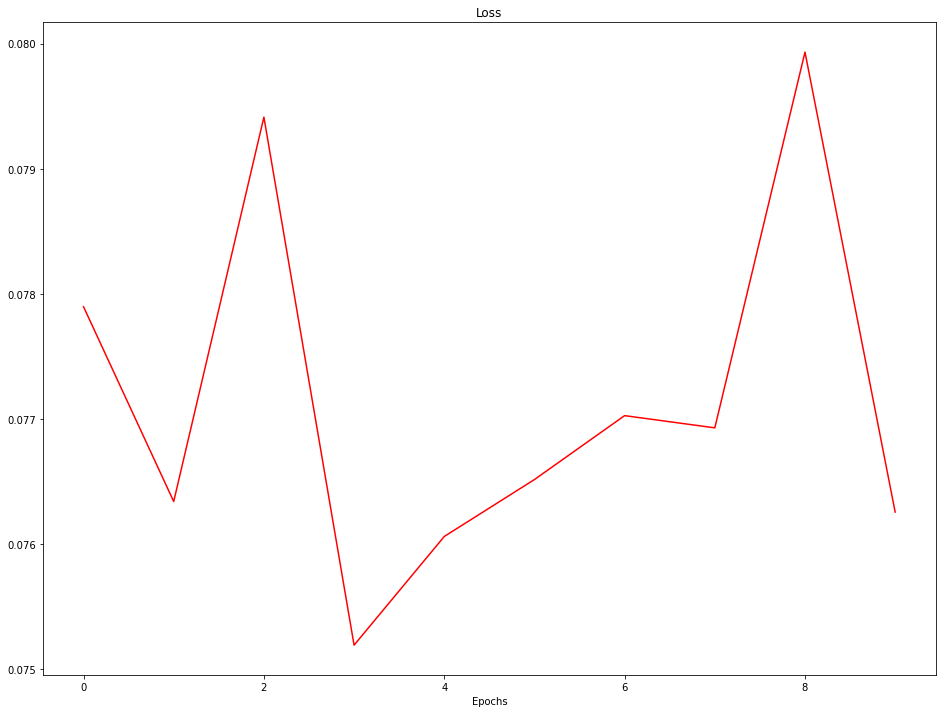

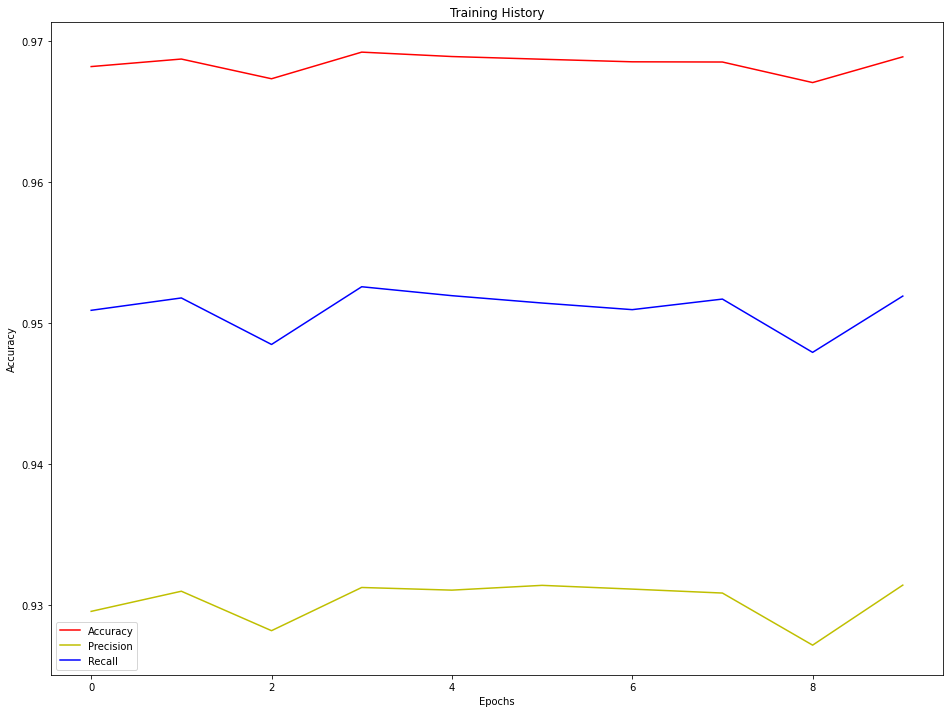

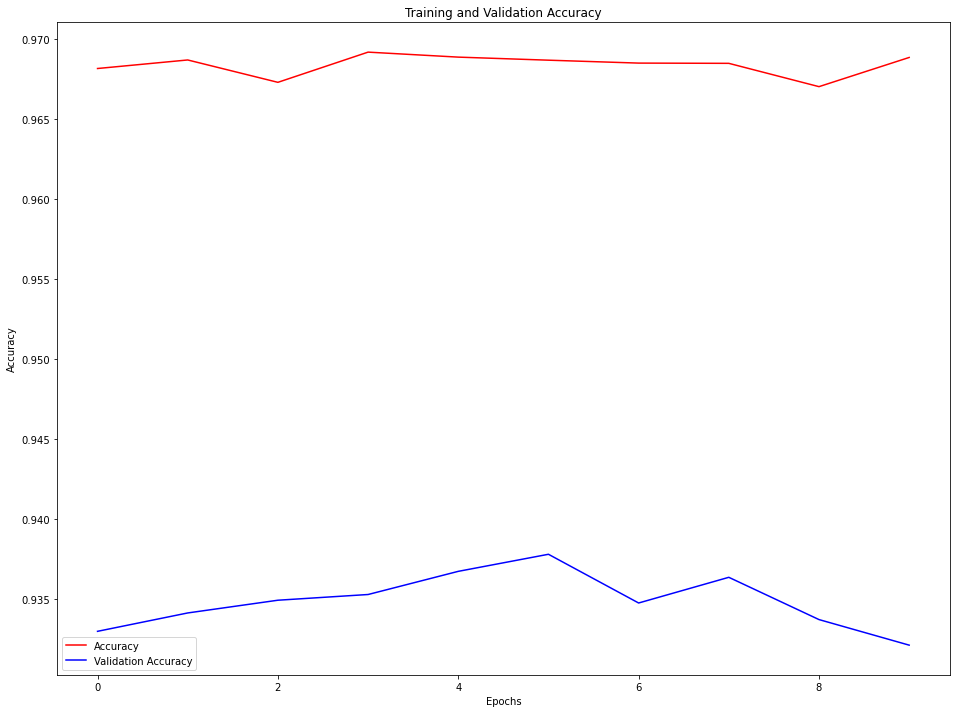

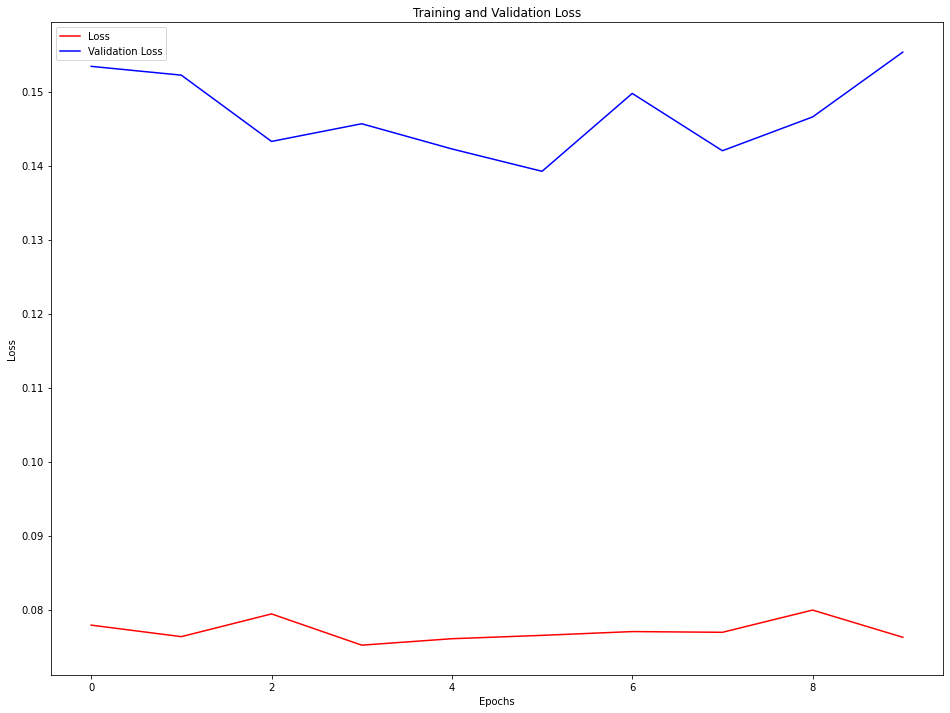

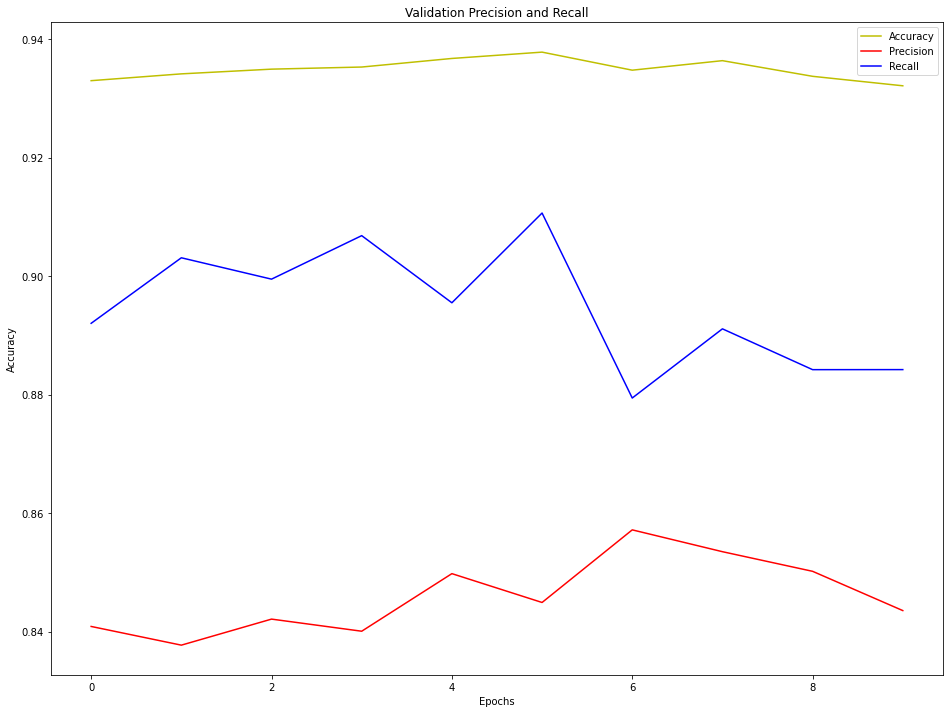

<Figure size 1152x864 with 0 Axes>

In [4]:
def results(history, mode="Associator"):
    # print(history.history)
    if mode == 'Associator':
        acc = history.history['acc']
        loss = history.history['loss']
        precision = history.history['precision']
        recall = history.history['recall']
        val_acc = history.history['val_acc']
        val_loss = history.history['val_loss']
        val_precision = history.history['val_precision']
        val_recall = history.history['val_recall']
        epochs = range(len(acc))

        plt.plot(epochs, loss, 'r')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.figure()

        plt.plot(epochs, acc, 'r')
        plt.plot(epochs, precision, 'y')
        plt.plot(epochs, recall, 'b')
        plt.title('Training History')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend(["Accuracy", "Precision", "Recall"])
        plt.figure()

        plt.plot(epochs, acc, 'r')
        plt.plot(epochs, val_acc, 'b')
        plt.title('Training and Validation Accuracy')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend(["Accuracy", "Validation Accuracy"])
        plt.figure()

        plt.plot(epochs, loss, 'r')
        plt.plot(epochs, val_loss, 'b')
        plt.title('Training and Validation Loss')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(["Loss", "Validation Loss"])
        plt.figure()

        plt.plot(epochs, val_acc, 'y')
        plt.plot(epochs, val_precision, 'r')
        plt.plot(epochs, val_recall, 'b')
        plt.title('Validation Precision and Recall')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend(["Accuracy", "Precision", "Recall"])
        plt.figure()
    else:
        loss = history.history['loss']
        loss_haversine = history.history['loss_haversine']
        loss_depth = history.history['loss_depth']
        loss_eventTime = history.history['loss_eventTime']
        val_loss = history.history['val_loss']
        val_loss_haversine = history.history['val_loss_haversine']
        val_loss_depth = history.history['val_loss_depth']
        val_loss_eventTime = history.history['val_loss_eventTime']
        epochs = range(len(loss))

        plt.plot(epochs, loss_haversine, 'b')
        plt.plot(epochs, val_loss_haversine, 'r')
        plt.title('Haversine Loss')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(["Training", "Validation"])
        plt.figure()

        plt.plot(epochs, loss_depth, 'b')
        plt.plot(epochs, val_loss_depth, 'r')
        plt.title('Depth Loss')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(["Training", "Validation"])
        plt.figure()

        plt.plot(epochs, loss_eventTime, 'b')
        plt.plot(epochs, val_loss_eventTime, 'r')
        plt.title('Event Time Loss')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(["Training", "Validation"])
        plt.figure()

# trainingEvents, trainingEventList = generateEventFile(params, trainingSet=True)
validationEvents, validationEventList = generateEventFile(params, trainingSet=False)

if params['trainingMode'] == 'Associator':
    history = PhaseAssociator(epochs=params['epochs'], weight=params['trainingWeight'])
else:
    history = Locator(epochs=params['epochs'])

print(history.history)
results(history, mode=params['trainingMode'])

In [6]:
import numpy as np
import pandas as pd
import json
from copy import deepcopy
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
from tensorflow.keras.models import load_model
from obspy import UTCDateTime
from Utils import loss_haversine, loss_depth, loss_eventTime, nonzero_mse, evaluate
batch_size = 1024

def permute_seq(X, timeNormalize, associationWindow, maxArrivals):
    X0 = np.zeros((X.shape[0], maxArrivals, X.shape[1]))
    for i in range(X.shape[0]):
        i_start = i
        i_end = i + maxArrivals
        if i_end > X.shape[0]:
            i_end = X.shape[0]
        # Map picks for slice into new array
        X0[i_start,:(i_end-i_start),:] = X[i_start:i_end,:]
        # Set initial pick to t=0
        idx = np.where(X0[i,:,2] > 0)[0]
        X0[i,idx,2] -= X0[i,0,2]
        # Remove all times with t > event_window
        idx = np.where(X0[i,:,2] > associationWindow)[0]
        X0[i,idx,:] = 0
        # Normalize time values
        X0[i,:,2] /= timeNormalize
    return X0

def link_phases(Y, min_nucl, min_merge):
    clusters = []
    for i in range(Y.shape[0]):
        idx = np.where(Y[i,:] == 1)[0]
        if idx.size < min_nucl:
            continue
        idx += i
        idx = idx[np.where(idx < Y.shape[0])[0]]
        idx_set = set(idx)
        if len(clusters) == 0:
            clusters.append(idx_set)
            continue
        n_common = np.zeros(len(clusters))
        for j, cluster in enumerate(clusters):
            n_common[j] = len(cluster.intersection(idx_set))
        best = np.argmax(n_common)
        if n_common[best] < min_merge:
            clusters.append(idx_set)
        else:
            clusters[best].update(idx_set)
    return np.array(clusters)

def run_phaselink(X, labels, params):
    # Permute arrival matrix for all lags 
    print("Permuting sequence for all lags... ", end='')
    X_perm = permute_seq(X, params['timeNormalize'], params['associationWindow'], params['maxArrivals'])

    # Predict association labels for all windows
    Y_pred = np.zeros((X_perm.shape[0], X_perm.shape[1], 1))
    print("\rPredicting phase associations...  ", end='')
    for i in range(0, Y_pred.shape[0], batch_size):
        i_start = i
        i_stop = i + batch_size
        if i_stop > Y_pred.shape[0]:
            i_stop = Y_pred.shape[0]
        X_test = {"phase": X_perm[i_start:i_stop,:,3], "numerical_features": X_perm[i_start:i_stop,:,[0,1,2,4]]}
        Y_pred[i_start:i_stop] = associatorModel.predict(X_test)
    Y0 = np.round(Y_pred)
    print("\rLinking phases...               ", end='')
    clusters = link_phases(Y0, params['minNucl'], params['minMerge'])
    print("\r%d events detected initially.       " % len(clusters))

    # Remove duplicate phases and events below threshold
    print("Removing duplicate phases... ", end='')
    for i, cluster in enumerate(clusters):
        phases = {}
        for idx in cluster:
            if idx >= len(labels):
                continue
            phase = labels[idx]
            phase = (phase.ST_LAT, phase.ST_LON, phase.IPHASE)
            if phase not in phases:
                phases[phase] = [idx]
            else:
                phases[phase].append(idx)
        for key in phases:
            if len(phases[key]) > 1:
                sorted(phases[key])
                phases[key] = [phases[key][-1]]
        clusters[i] = [phases[key][0] for key in phases]

    clusters = [x for x in clusters if len(x) >= params['minArrivals']]
    print("{} events left after duplicate removal and applying threshold.".format(len(clusters)))

    # Pull arrivals from predicted events to predict locations for said events
    constructedEvents = np.zeros((len(clusters),params['maxLocatorArrivals'],5))
    for event in range(len(clusters)):
        constructedEvents[event,:len(clusters[event])] = [X[arrival] for arrival in clusters[event]][:params['maxLocatorArrivals']]
        constructedEvents[event,:,2] -= constructedEvents[event,0,2]
    constructedEvents[:,:,2] /= params['timeNormalize']
    constructedEvents = {"phase": constructedEvents[:,:,3], "numerical_features": constructedEvents[:,:,[0,1,2,4]]}
    
    # Predict event locations and times
    locations = locatorModel.predict(constructedEvents)

    # Write output file
    EID = 0
    for i, cluster in enumerate(clusters):
        idx = np.array(list(cluster))
        for j in idx:
            thisArrival = deepcopy(labels[j])
            thisArrival.EVID = EID
            lat,lon,dep,time = locations[i]
            thisArrival['LAT'] = lat
            thisArrival['LON'] = lon
            thisArrival['DEPTH'] = dep
            thisArrival['EV_TIME'] = time
            outputs.append(thisArrival)
        EID += 1
        print("\rWriting output event " + str(EID) + ' / ' + str(len(clusters)), end='')
    print()
    return len(clusters)

def processInput(params):
    print("Reading input file")
    phases = params['phases']
    extents = np.array(list(params['extents'][params['location']].values()))
    latRange = abs(extents[1] - extents[0])
    lonRange = abs(extents[3] - extents[2])
    X = []
    labels = []
    for i, r in inputs.iterrows(): # I can do this better
        phase = r.IPHASE
        time = UTCDateTime(r.TIME)
        lat = abs((r.ST_LAT - extents[0]) / latRange)
        lon = abs((r.ST_LON - extents[2]) / lonRange)
        otime = time - UTCDateTime(0)
        try:
            arrival = [lat, lon, otime, phases[phase], 1]
            X.append(arrival)
            labels.append(r)
        except Exception as e:
            print(e)
    X = np.array(X)
    idx = np.argsort(X[:,2])
    X = X[idx,:]
    X[:,2] -= X[0,2]
    labels = [labels[i] for i in idx]
    print("Finished processing input file: %d arrivals found" % len(labels))
    return X, labels

if __name__ == "__main__":
    with open("Parameters.json", "r") as f:
        params = json.load(f)

    associatorModel = load_model(params['models']['associator'], compile=False)
    locatorModel = load_model(params['models']['locator'], custom_objects={'loss_haversine':loss_haversine, 'loss_depth':loss_depth, 'loss_eventTime':loss_eventTime, 'nonzero_mse':nonzero_mse})

    inputs = pd.read_pickle(params['evalInFile']).sort_values(by=['TIME'])
    
    # inFiles = ['./Inputs/S1 1.0.gz', './Inputs/S1 0.5.gz', './Inputs/S1 0.25.gz', './Inputs/S1 TEST.gz']
    # for i in range(len(inFiles)):
    #     inputs = pd.read_pickle(inFiles[i])
    #     params['evalInFile'] = inFiles[i]
    #     if i != 3:
    #         inputs = inputs[100000:105000]

    X, labels = processInput(params)
    global outputs
    outputs = []
    
    detections = run_phaselink(X, labels, params)
    outputs = pd.DataFrame(outputs)
    outputs.to_pickle(params['evalOutFile'])
    print("{} detections total".format(detections))
        
    evaluate(params, inputs, outputs, locatorModel, verbose=False)

Reading input file
Finished processing input file: 5000 phases found.
710 events detected initially.       
Removing duplicate phases... 710 events left after duplicate removal and applying threshold.
Writing output event 710 / 710
710 detections total
Evaluating event 715 / 715        
Evaluating precision/recall/location for event 715 / 715        
                 0
count   715.000000
mean    994.094800
std     375.128514
min     253.058662
25%     672.080817
50%     996.886640
75%    1359.459803
max    2004.810435
-----------------------------
IoU evaluation for events with at least 3 picks for model ./Models/Associator/024 - L0.1401 - A0.9316 - P0.8649 - R0.9100
Parameters - eval_in_file: ./Inputs/S1 TEST.gz	max_picks: 20	min_nucl: 3	min_merge: 1	t_win: 120
Totals/Average IoU Actual-Picked: 4864 / 5057 = 0.9618350800870081
Precision: 0.98721331439
Recall: 0.973968762515
F1: 0.980546315896
Number of fake picks: 0 / 0
Picked / Actual Events: 710 / 715
Missed events: 14 / 715
Arbitra